In [1]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


# Data prep

## This section is to prepare the data into the proper format for time series forecasting using TensorFlow

### There are may ways to archetect a ML solution for TS forecasting - this one will use one of the most cutting edge methods LSTM (long/short term memory) models in a sequence to sequence archeitecture (seq2seq). 

Seq 2 seq is popular in many application surrounding machine translation (english to french, etc..). This makes sense as we will be taking a time series sequence of inputs to predict a time series output of predicted values

For this example, we will be using the Melbourne Daily min tempuratures dataset 
https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

to illustrate how this technique works. Note that there is only one feature and target/label here, but LSTMs take 3D shapes (n_observations, n_timesteps, n_features), and we will only be dealing with 1 element for the features

# Import and prep the data

,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


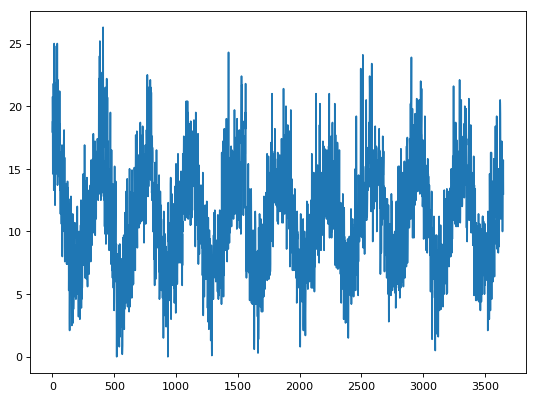

In [28]:
from matplotlib import pyplot as plt
import re
from matplotlib.pyplot import figure


%matplotlib inline

pandas_data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', sep=';', encoding='utf-8' )

columns = ['date', 'temp']

pandas_data.columns = columns

pandas_data['date'] = pd.to_datetime(pandas_data['date'])

pandas_data['temp'] = pandas_data['temp'].str.extract('(\d+.\d)', expand=False) #funky characters in data

pandas_data['temp'] = pandas_data['temp'].astype('float32')

pandas_data['temp'] = pandas_data['temp'].apply(lambda x: round(x,1)) #fp conversion created some noise
 
    
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

pandas_data['temp'].plot()

# pyplot.show
pandas_data.head(10)

In [3]:
pandas_np = pandas_data['temp'].values

nobs = pandas_np.shape[0]

train_obs = int(0.75 * nobs)

# we need to create a function that reshapes the data to have each observation as a time series
# and each prediction as a time series
# inspiration here: https://stackoverflow.com/questions/21229503/creating-an-numpy-matrix-with-a-lag

def lagLead4LSTM(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

lag = 90
lead = 30

x1  = lagLead4LSTM(pandas_np, lag)

x = x1[:-lead,] # get rid of last observations with no lags
    

In [4]:


pandas_np.shape, x1.shape, x.shape, pandas_np[lag-1:,].shape

((3650,), (3561, 90), (3531, 90), (3561,))

In [5]:
y = lagLead4LSTM(pandas_np[lag:,],lead) 

print(x[4], y[3]) 
#last element should be same as first (tommorows data = first datapoint in y)

"the shapes for x are: {} and the shapes for y are: {}".format(x.shape, y.shape)

[15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8
 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2 15.5 15.1 15.4 15.3
 18.8 21.9 19.9 16.6 16.8 14.6 17.1 25.  15.  13.7 13.9 18.3 22.  22.1
 21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5 21.2 17.8
 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8 11.3 10.6
 11.7 14.2 11.2 16.9 16.7  8.1  8.   8.8 13.4 10.9 13.4 11.  15.  15.7
 14.5 15.8 16.7 16.8 17.5 17.1] [17.1 18.1 16.6 10.  14.9 15.9 13.   7.6 11.5 13.5 13.  13.3 12.1 12.4
 13.2 13.8 10.6  9.  10.   9.8 11.5  8.9  7.4  9.9  9.3  9.9  7.4  8.6
 11.9 14. ]


'the shapes for x are: (3531, 90) and the shapes for y are: (3531, 30)'

# The data is now in the shape for us to to a seq2seq model
## We are using the last 30 days to predict the next 7 days

First, we need to split the data and scale it on a 0-1

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(pandas_np.reshape(-1,1))

pandas_np_scaled = scaler.transform(pandas_np.reshape(-1,1))

pandas_np_scaled

trainN = int(0.75 * pandas_np_scaled.shape[0]) # will take only the first 75 percent days

trainRaw = pandas_np_scaled[:trainN,-1]

testRaw = pandas_np_scaled[trainN+1:,-1]


In [18]:
# updatable plot
# a minimal example (sort of)
import keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('acc'))
        self.val_accuracies.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracies, label="acc")
        plt.plot(self.x, self.val_accuracies, label="val_acc")
        plt.legend()
        plt.show()
        plt.rcParams["figure.figsize"] = [16,9]
        
plot_losses = PlotLosses()

In [7]:
"The number of train cases are {} days, test cases are {} days".format(trainRaw.shape[0], testRaw.shape[0])

'The number of train cases are 2737 days, test cases are 912 days'

In [20]:
#reapply the transform above now we are split and scaled
lag = 90
lead = 30

def reshapeDataXY(rawData, lag=lag, lead=lead):
    x = lagLead4LSTM(rawData, lag)
    x = x[:-lead,]
    xs1, xs2 = x.shape
    x = x.reshape(xs1, xs2, 1) #need 1 for the one feature
    y = lagLead4LSTM(rawData[lag:,],lead) 
    ys1, ys2 = y.shape
    y = y.reshape(ys1, ys2, 1)
    return x, y


xTrain, yTrain = reshapeDataXY(trainRaw)
xTest, yTest = reshapeDataXY(testRaw)

# create padded input target sequence
decodeY = np.zeros((yTrain.shape))
decodeY[:,1:,:] = yTrain[:,:-1,:]
# print(yTrain[2])
# print(decodeY[2])

In [21]:
print(xTrain.shape, yTrain.shape, decodeY.shape)

(2618, 90, 1) (2618, 30, 1) (2618, 30, 1)


# Now to setup the LSTM seq2seq model
from: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Here is an example of the architecture in the context of machine translation:

![](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)


An excellent explination of GRUs and LSTMs are here

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![](https://cdn-images-1.medium.com/max/1600/1*VOXRGhOShoWWks6ouoDN3Q.gif)

In [30]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout


num_encoder_tokens = 1
num_decoder_tokens = 1
num_input_features = 1

layers = [32,16]
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=None,
                                              recurrent_regularizer=None,
                                              bias_regularizer=None))

    
encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))
dropout="sure"
decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=None,
                                              recurrent_regularizer=None,
                                              bias_regularizer=None))


decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(1,
                                   activation='linear',
                                   kernel_regularizer=None,
                                   bias_regularizer=None)

decoder_outputs = decoder_dense(decoder_outputs)
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
rnn_9 (RNN)                     [(None, 16), (None,  5616        input_13[0][0]                   
__________________________________________________________________________________________________
rnn_10 (RNN)                    [(None, None, 16), ( 5616        input_14[0][0]                   
                                                                 rnn_9[0][1]                      
          

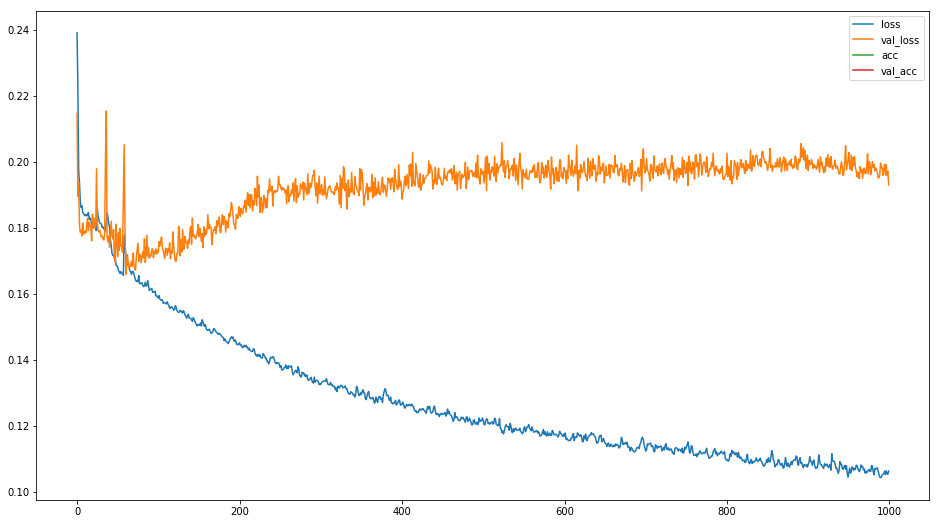

In [24]:
# Run training
from IPython.display import clear_output
    
batch_size = 512
epochs = 1000

#research - forced teaching (shifted by one input for decoder) does not perform well
decodeY = np.zeros(decodeY.shape)

learning_rate = 0.01
decay = 0.99 # Learning rate decay
beta2 = .95

optimizer = keras.optimizers.Adam(lr=learning_rate, beta_2=beta2)

model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = model.fit([xTrain, decodeY], yTrain,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
         callbacks=[plot_losses])

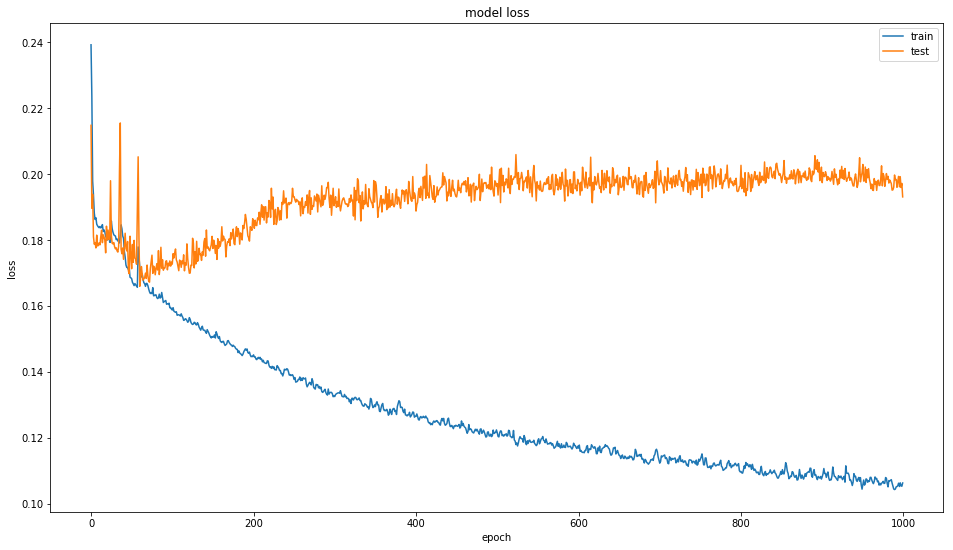

In [25]:
# summarize history for accuracy
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Inference setup

In [32]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# this loops 
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)


decoder_predict_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
rnn_10 (RNN)                    [(None, None, 16), ( 5616        input_14[0][0]                   
                                                                 input_17[0][0]                   
          

In [27]:
# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model=encoder_predict_model
            , decoder_predict_model=decoder_predict_model, num_steps_to_predict=lead):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [ ]:
#print random plots for every 1000 steps

step = 130
offset = 365
for i in range(10):

    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    test_line = i * step + offset

    xLine = xTest[test_line,:]
    yLine = yTest[test_line,:]

    xLine = xLine.reshape(1, lag, 1)
    yHat = predict(xLine, num_steps_to_predict=30)
    hist = np.vstack((xLine.reshape(lag, 1), -1*np.ones(yLine.shape)))
    hist[hist == -1] = np.nan
    plt.plot(hist)
    plt.plot()
    preds = np.vstack((-1*np.ones((lag, 1)), yHat[0,:]))
    preds[preds == -1] = np.nan
    plt.plot(preds)
    acts = np.vstack((-1*np.ones((lag, 1)),yLine))
    acts[acts == -1] = np.nan
    plt.plot(acts)
    plt.legend(['historic', 'predicted', 'actual'], loc='lower left')

    plt.show()

#print(yHat, yLine)
#yHat.shapevalues[ values==0 ] = np.nan

In [ ]:
encoder_predict_model.save('models/gru_encoder_012019.h5')
decoder_predict_model.save('models/gru_decoder_012019.h5')